# imports

In [1]:
import pathlib
import re
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
import torch.nn as nn
import nltk
from nltk.corpus import stopwords
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
import pymorphy3
import time
from sklearn.utils import shuffle 
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import re
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import random
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
from transformers import pipeline
from typing import Optional

from torch.optim import AdamW
from tqdm import tqdm
import emoji

from transformers import get_linear_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AutoModelForSequenceClassification 
from transformers import AdamW, AutoModel
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [2]:
# tensorboard --logdir=runs --port=6007

# variables

In [3]:
ROOT_DIR = pathlib.Path().absolute()
DATA_DIR = os.path.join(ROOT_DIR, "data")
RANDOM_SEED = 42

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

THRESHOULD = 0.5

nltk.download('stopwords')
STOPS = set(stopwords.words('russian'))

MORPH = pymorphy3.MorphAnalyzer()

TARGET_COLS = [f'trend_id_res{i}' for i in range(50)]

AUG_FILE_NAME = "no_aug" # "no_aug" or "имя_файла_с_аугментацией"

TAG_ADDING = "tag_add" # "tag_add" or "no_tag"

# для модели fine_tuned_model_1728380842_rubert_adamw_focal_loss_tag_add_no_aug_data_split_50_LR_2e-05__alpha_0_1
# было "data_split"
# для других "no_split"
DATA_SPLIT = "no_split" # "no_split" or "data_split"



# для моделей
# fine_tuned_model_1728380842_rubert_adamw_focal_loss_tag_add_no_aug_data_split_50_LR_2e-05__alpha_0_1
# fine_tuned_model_1728416226_rubert_adamw_focal_loss_tag_add_no_aug_no_split_17_LR_2e-05_sigmoida_alpha_0_25_gamma_3

# tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
# max_length=512


# для моделей
# fine_tuned_model_1728477275_LaBSE_adamw_focal_loss_tag_add_no_aug_no_split_10_LR_2e-05__no_lower_alpha_0_25_gamma_3

tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
max_length=64


cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alsuy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# read data

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
len(train_df), len(test_df)

(4623, 9015)

# exploratory

In [5]:
train_df.head(2)

,Unnamed: 0,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df.head(2)

,Unnamed: 0,index,assessment,tags,text
0,1,3135,3.0,{DELIVERY},"Последнее время думаю плохо, сроки доставки да..."
1,3,4655,2.0,"{PRICE,DELIVERY,ASSORTMENT}",Цены намного выше магазинных но радуют акции


## spec.tokens

In [7]:
texts = train_df["text"].fillna("").tolist()

def find_unique_tokens(strings):
    # Функция для поиска токенов вида [DATA], [NUM], [INFO] и т.п.
    pattern = r'\[[A-Z]+\]'
    
    unique_tokens = set()
    
    for string in strings:
        matches = re.findall(pattern, string)
        unique_tokens.update(matches)
    
    return list(unique_tokens)

result = find_unique_tokens(texts)
result

['[PHONE]', '[NUM]']

## graphs

0


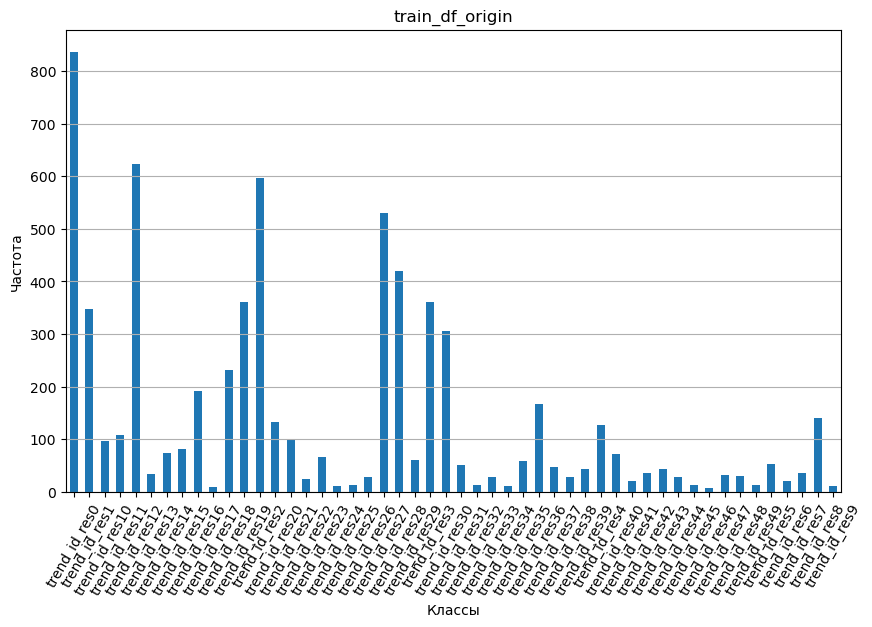

In [8]:
train_df_origin = train_df[TARGET_COLS].copy()

train_df_origin['target'] = train_df_origin.apply(
    lambda row: ' '.join(row.index[row == 1].astype(str)) if row.any() else np.nan, axis=1
)
print(train_df_origin['target'].isna().sum())

class_counts = train_df_origin['target'].str.split(expand=True).stack().value_counts().sort_index()

# Построение гистограммы
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('train_df_origin')
plt.xlabel('Классы')
plt.ylabel('Частота')
plt.xticks(rotation=60)  # Поворачиваем метки по оси X для удобства
plt.grid(axis='y')

# Показать график
plt.show()

count    4623.000000
mean       87.105775
std        74.425236
min         1.000000
25%        28.000000
50%        64.000000
75%       125.000000
max       279.000000
Name: text_len, dtype: float64

<Axes: >

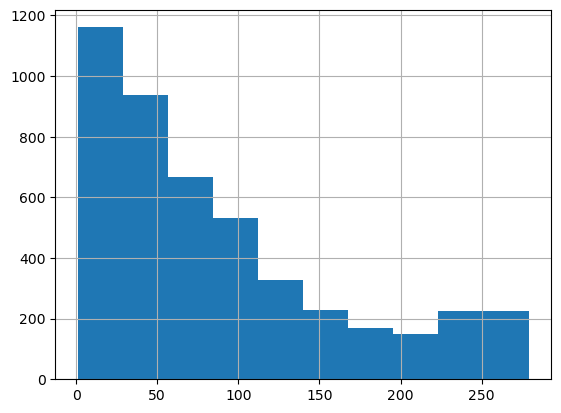

In [9]:
train_df["text_len"] = train_df["text"].apply(lambda x: len(x))
display(train_df["text_len"].describe())
train_df["text_len"].hist()

## samples

In [10]:
train_df_sample = train_df.sample(5)
for text, tags  in zip(
    train_df_sample["text"].values,
    train_df_sample["tags"].values
):
    print(text)
    print(tags, "\n")

Очень долго собираются заказы и курьеры едут дольше заявленного времени
{ASSORTMENT,PRICE,PROMOTIONS,CATALOG_NAVIGATION,DELIVERY,PRODUCTS_QUALITY} 

Хотелось бы, чтобы цены были ниже. Тогда и заказывали бы у вас намного чаще. В магазинах все намного дешевле
{PRICE,PROMOTIONS,ASSORTMENT} 

Норм
{ASSORTMENT,PRICE,PROMOTIONS,CATALOG_NAVIGATION} 

Долго
{DELIVERY} 

Бывает доставляют за [NUM] минут, а бывает один хлеб ждешь [NUM] часа. Пока дождешься уже ничего не нужро
{DELIVERY,PRICE,SUPPORT} 



# data preprocessing

## tags

In [11]:
def tags_translation(tags):
    return tags.replace("ASSORTMENT", "ассортимент")\
                .replace("DELIVERY", "доставка")\
                .replace("SUPPORT", "служба поддержки")\
                .replace("PRICE", "цена")\
                .replace("PROMOTIONS", "реклама")\
                .replace("PRODUCTS_QUALITY", "качество продуктов")\
                .replace("CATALOG_NAVIGATION", "навигация по каталогу")\
                .replace("PAYMENT", "способ оплаты")

test_df["tags"] = test_df["tags"].fillna("{}")
train_df["tags"] = train_df["tags"].fillna("{}")

test_df["tags"] = test_df["tags"].map(tags_translation)
train_df["tags"] = train_df["tags"].map(tags_translation)

## text

In [12]:
def preprocess_text(
    text,
    normalize_spaces=True,
    filter_4_and_more_repeats=True,
    demojize=True,
    drop_stops=False, 
    lemmatize=False, 
    stops=STOPS, 
    morph=MORPH,
    make_lower = False,
    capitalize_special_tokens=True,
):
    if normalize_spaces:
        text = re.sub(r'\s+', ' ', text).strip()
    if filter_4_and_more_repeats:  
        text = re.sub(r'(.)\1{3,}', r'\1\1\1', text)
    if demojize:
        text = emoji.demojize(text, language='ru')
    if drop_stops:
        text = " ".join([word for word in text.split() if word not in stops])
    if lemmatize:
        text = " ".join([morph.parse(word)[0].normal_form for word in text.split()])
    if make_lower:
        text = text.lower()

    if capitalize_special_tokens:
        pattern = r'\[[a-z]+\]'
        def to_upper(match):
            return match.group(0).upper()
        text = re.sub(pattern, to_upper, text)
    return text


train_df["text"] = train_df["text"].fillna("")
train_df['text'] = train_df['text'].apply(
    preprocess_text,
    normalize_spaces=True,
    filter_4_and_more_repeats=True,
    demojize=True,
    drop_stops=False, 
    lemmatize=False,
    make_lower=True,
    capitalize_special_tokens=True,
)

test_df["text"] = test_df["text"].fillna("")
test_df['text'] = test_df['text'].apply(
    preprocess_text,
    normalize_spaces=True,
    filter_4_and_more_repeats=True,
    demojize=True,
    drop_stops=False, 
    lemmatize=False,
    make_lower=True,
    capitalize_special_tokens=True,
)

# augmentation

In [13]:
if AUG_FILE_NAME != "no_aug":
    aug_df = pd.read_csv(os.path.join(DATA_DIR, AUG_FILE_NAME + ".csv"), sep="$")

    aug_df['text'] = test_df['text'].apply(
        preprocess_text,
        normalize_spaces=True,
        filter_4_and_more_repeats=True,
        demojize=True,
        make_lower=True,
        capitalize_special_tokens=True,
    )

    print(len(aug_df))
    display(aug_df.head(2))

    print(f"До аугментации: {len(train_df)}")
    train_df = pd.concat([aug_df, train_df], axis=0, ignore_index=True)
    print(f"После аугментации: {len(train_df)}")
    train_df = train_df.drop_duplicates(subset=["text"])
    print(f"После удаления дубликатов: {len(train_df)}")


    train_df_aug = train_df[TARGET_COLS].copy()
    train_df_aug['target'] = train_df_aug.apply(
        lambda row: ' '.join(row.index[row == 1].astype(str)) if row.any() else np.nan, axis=1
    )
    print(train_df_aug['target'].isna().sum())

    class_counts = train_df_aug['target'].str.split(expand=True).stack().value_counts().sort_index()

    # Построение гистограммы
    plt.figure(figsize=(10, 6))
    class_counts.plot(kind='bar')
    plt.title('train_df после аугментации')
    plt.xlabel('Классы')
    plt.ylabel('Частота')
    plt.xticks(rotation=45)  # Поворачиваем метки по оси X для удобства
    plt.grid(axis='y')

    # Показать график
    plt.show()

# data prepering for training

## target preparing

In [14]:
train_df['target'] = train_df.apply(
    lambda row: row[TARGET_COLS].tolist(),
    axis=1
)
labels = torch.tensor(train_df['target'].tolist(), dtype=torch.float32)

## index preparing

In [15]:
train_df.index = train_df["index"]
test_df.index = test_df["index"]

## tags adding

In [16]:
if TAG_ADDING == "tag_add":
    def add_tags(row):
    # Объединяем текст отзыва и теги
        return row['text'] + "\n[TAGS] " + row['tags']
    train_df["text"] = train_df.apply(add_tags, axis=1)
    test_df["text"] = test_df.apply(add_tags, axis=1)

# training

## data split

In [17]:
if DATA_SPLIT == "data_split":
    threshold = round(len(train_df) * 0.8)
    val_df = train_df[threshold:]
    train_df = train_df[:threshold]

## tokenizing -> loader

In [18]:
train_encodings = tokenizer(
        train_df['text'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

test_encodings = tokenizer(
        test_df['text'].tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

if DATA_SPLIT == "data_split":
    val_encodings = tokenizer(
            val_df['text'].tolist(),
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )
    
class MultiLabelDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item
    

train_dataset = MultiLabelDataset(train_encodings, train_df["target"].tolist())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
if DATA_SPLIT == "data_split":
    val_dataset = MultiLabelDataset(val_encodings, val_df["target"].tolist())
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## training params

In [19]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        targets = targets.type(torch.float32)
        
        # Focal loss calculation
        pt = torch.exp(-BCE_loss)  # Probability of true class
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss

In [20]:
def training(
    run_name,
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    epochs,
    device,
    scheduler=None,
    early_stop=True,
    early_stopping_patience=3,  # Параметр для раннего прекращения
    threshold=0.5,
):
    # TensorBoard
    writer = SummaryWriter(log_dir=f"runs/{run_name}")

    model = model.to(device)

    def compute_accuracy(preds, labels):
        # Функция для расчета Accuracy
        preds = (preds > threshold).float()  # Бинаризация предсказаний
        return accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())

    best_val_accuracy = 0
    patience_counter = 0

    # Обучение модели
    for epoch in tqdm(range(epochs)):
        model.train()
        train_preds = []
        train_labels = []
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            train_preds.append(torch.sigmoid(outputs.logits))
            train_labels.append(labels)

            loss = criterion(outputs.logits, labels)
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)
        train_accuracy = compute_accuracy(train_preds, train_labels)
        writer.add_scalar("Accuracy/train", train_accuracy, epoch)

        avg_loss = total_loss / len(train_loader)
        writer.add_scalar("Loss/train", avg_loss, epoch)

        print(
            f"Epoch {epoch + 1}/{epochs}\nTrain loss: {avg_loss:.4f}, Train acc: {train_accuracy:.4f}"
        )
        if DATA_SPLIT == "data_split":
            # Валидация
            model.eval()
            val_preds = []
            val_labels = []
            total_loss = 0
            with torch.no_grad():
                for val_batch in val_loader:
                    val_input_ids = val_batch["input_ids"].to(device)
                    val_attention_mask = val_batch["attention_mask"].to(device)
                    val_labels_batch = val_batch["labels"].to(device)

                    val_outputs = model(
                        val_input_ids, attention_mask=val_attention_mask
                    )
                    val_preds.append(torch.sigmoid(val_outputs.logits))
                    val_labels.append(val_labels_batch)

                    loss = criterion(val_outputs.logits, val_labels_batch)
                    total_loss += loss.item()

            val_preds = torch.cat(val_preds)
            val_labels = torch.cat(val_labels)
            val_accuracy = compute_accuracy(val_preds, val_labels)
            writer.add_scalar("Accuracy/val", val_accuracy, epoch)

            avg_loss = total_loss / len(val_loader)
            writer.add_scalar("Loss/val", avg_loss, epoch)

            print(f"Val loss: {avg_loss:.4f}, Val acc: {val_accuracy:.4f}")

            if early_stop:
                # Раннее прекращение
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    patience_counter = 0
                    # Сохранение лучшей модели
                    model.save_pretrained(f"fine_tuned_model_{run_name}")
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        print("Early stopping triggered.")
                        break
    if DATA_SPLIT != "data_split":
        model.save_pretrained(f"fine_tuned_model_{run_name}")
    writer.close()

In [21]:
# # для модели fine_tuned_model_1728477275_LaBSE_adamw_focal_loss_tag_add_no_aug_no_split_10_LR_2e-05__no_lower_alpha_0_25_gamma_3

# MODEL_NAME = 'LaBSE'
# MODEL = AutoModelForSequenceClassification.from_pretrained("cointegrated/LaBSE-en-ru", num_labels=labels.shape[1])


# # для моделей
# # fine_tuned_model_1728416226_rubert_adamw_focal_loss_tag_add_no_aug_no_split_17_LR_2e-05_sigmoida_alpha_0_25_gamma_3
# # fine_tuned_model_1728380842_rubert_adamw_focal_loss_tag_add_no_aug_data_split_50_LR_2e-05__alpha_0_1

# # MODEL_NAME = 'rubert'
# # MODEL = BertForSequenceClassification.from_pretrained(
# #         'DeepPavlov/rubert-base-cased',
# #         num_labels=labels.shape[1]
# #         )

# LR = 2e-5
# # для модели fine_tuned_model_1728380842_rubert_adamw_focal_loss_tag_add_no_aug_data_split_50_LR_2e-05__alpha_0_1
# # было использовано 50 эпох с остановкой на 19 по раннему стопу
# # EPOCHS = 50

# # для модели fine_tuned_model_1728416226_rubert_adamw_focal_loss_tag_add_no_aug_no_split_17_LR_2e-05_sigmoida_alpha_0_25_gamma_3
# # было использовано 17 эпох
# # EPOCHS = 17

# # для модели fine_tuned_model_1728477275_LaBSE_adamw_focal_loss_tag_add_no_aug_no_split_10_LR_2e-05__no_lower_alpha_0_25_gamma_3
# # было использовано 10 эпох
# EPOCHS = 10

# OPTIMIZER_NAME = 'adamw'
# OPTIMIZER = AdamW(MODEL.parameters(), lr=LR, correct_bias=False)

# SCHEDULER = None

# CRITERION_NAME = 'focal_loss'
# # для модели fine_tuned_model_1728380842_rubert_adamw_focal_loss_tag_add_no_aug_data_split_50_LR_2e-05__alpha_0_1
# # alpha=0.1
# # для остальных: alpha=0.25
# CRITERION = FocalLoss(alpha=0.75, gamma=3.0, reduction='mean')


# ADD_COMM = "_alpha_0_75_gamma_3"

# RUN_NAME = f"{int(time.time())}_{MODEL_NAME}_{OPTIMIZER_NAME}_{CRITERION_NAME}_{TAG_ADDING}_{AUG_FILE_NAME}_{DATA_SPLIT}_{EPOCHS}_LR_{LR}_{ADD_COMM}"
# print(RUN_NAME)

# if DATA_SPLIT == "data_split":
#         training(
#                 run_name=RUN_NAME, 
#                 model=MODEL, 
#                 optimizer=OPTIMIZER, 
#                 criterion=CRITERION, 
#                 train_loader=train_loader, 
#                 val_loader=val_loader, 
#                 epochs=EPOCHS,
#                 device=DEVICE,
#                 scheduler=SCHEDULER,
#                 early_stop=True,
#                 early_stopping_patience=2,
#                 threshold=THRESHOULD
#         )
# else:
#         training(
#                 run_name=RUN_NAME, 
#                 model=MODEL, 
#                 optimizer=OPTIMIZER, 
#                 criterion=CRITERION, 
#                 train_loader=train_loader, 
#                 val_loader=None, 
#                 epochs=EPOCHS,
#                 device=DEVICE,
#                 scheduler=SCHEDULER,
#                 early_stop=True,
#                 early_stopping_patience=2,
#                 threshold=THRESHOULD
#         )

# inference

In [22]:
# для fine_tuned_model_1728380842_rubert_adamw_focal_loss_tag_add_no_aug_data_split_50_LR_2e-05__alpha_0_1
# model_name = "fine_tuned_model_1728380842_rubert_adamw_focal_loss_tag_add_no_aug_data_split_50_LR_2e-05__alpha_0_1"
# model = BertForSequenceClassification.from_pretrained(model_name)

# для fine_tuned_model_1728416226_rubert_adamw_focal_loss_tag_add_no_aug_no_split_17_LR_2e-05_sigmoida_alpha_0_25_gamma_3
# model_name = "fine_tuned_model_1728416226_rubert_adamw_focal_loss_tag_add_no_aug_no_split_17_LR_2e-05_sigmoida_alpha_0_25_gamma_3"
# model = BertForSequenceClassification.from_pretrained(model_name)

# для fine_tuned_model_1728477275_LaBSE_adamw_focal_loss_tag_add_no_aug_no_split_10_LR_2e-05__no_lower_alpha_0_25_gamma_3
model_name = "fine_tuned_model_1728477275_LaBSE_adamw_focal_loss_tag_add_no_aug_no_split_10_LR_2e-05__no_lower_alpha_0_25_gamma_3"
model = AutoModelForSequenceClassification.from_pretrained(model_name)


model.eval()
model = model.to(DEVICE)

# Перемещение данных на устройство
input_ids = test_encodings['input_ids'].to(DEVICE)
attention_mask = test_encodings['attention_mask'].to(DEVICE)

# Получение предсказаний по частям
batch_size = 32
predictions = []

with torch.no_grad():
    for i in range(0, len(input_ids), batch_size):
        batch_input_ids = input_ids[i:i + batch_size]
        batch_attention_mask = attention_mask[i:i + batch_size]

        # Получение предсказаний
        outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
        logits = outputs.logits
        preds = torch.sigmoid(logits)
        predictions.append(preds)

# Объединение предсказаний
predictions = torch.cat(predictions)

# Применение порога для бинаризации предсказаний
binary_predictions = (predictions > THRESHOULD).float()

# Создание DataFrame с предсказаниями
predictions_df = pd.DataFrame(binary_predictions.cpu().numpy(), index=test_df.index)
predictions_df['target'] = predictions_df.apply(
    lambda row: ' '.join(row.index[row == 1].astype(str)) if row.any() else np.nan, axis=1
)

display(predictions_df.head())
predictions_df.reset_index()[["index", "target"]].to_csv("sub.csv", index=False)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,target
index,,,,,,,,,,,,,,,,,,,,,
3135,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1 2 12
4655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
22118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35
23511,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


## inference analysis

Всего NaN в трейне: 0


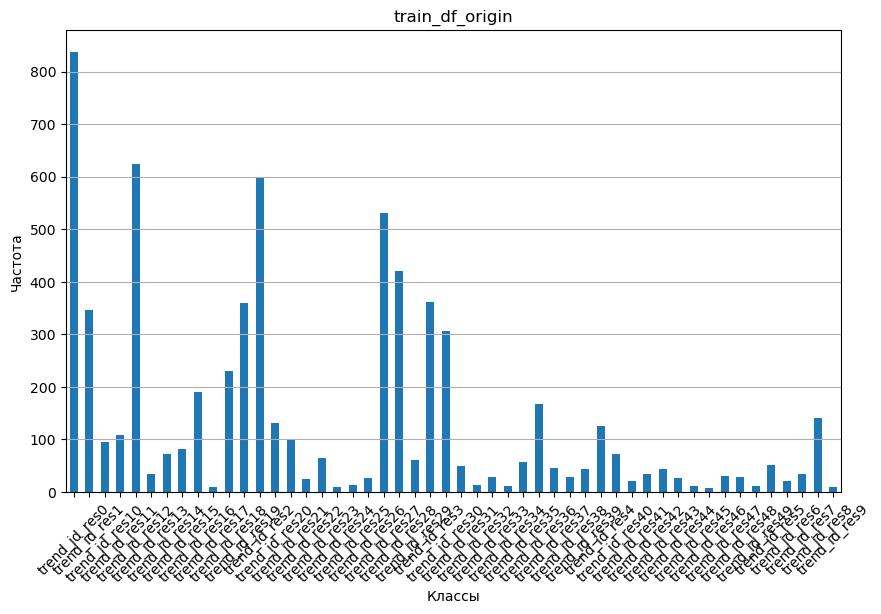

In [23]:
print("Всего NaN в трейне:", train_df_origin['target'].isna().sum())

class_counts = train_df_origin['target'].str.split(expand=True).stack().value_counts().sort_index()

# Построение гистограммы
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('train_df_origin')
plt.xlabel('Классы')
plt.ylabel('Частота')
plt.xticks(rotation=45)  # Поворачиваем метки по оси X для удобства
plt.grid(axis='y')

# Показать график
plt.show()

Всего NaN в предсказаниях: 757


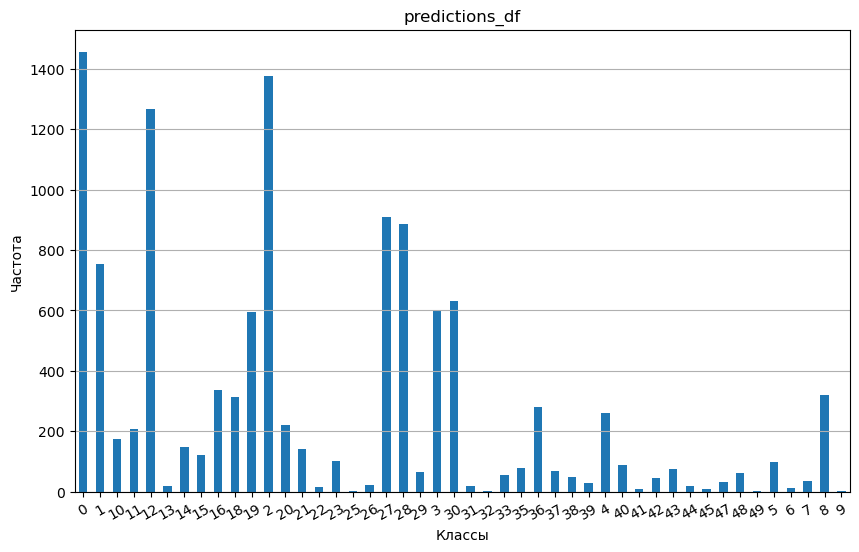

In [24]:
print("Всего NaN в предсказаниях:", predictions_df["target"].isna().sum())

class_counts = predictions_df['target'].str.split(expand=True).stack().value_counts().sort_index()

# Построение гистограммы
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('predictions_df')
plt.xlabel('Классы')
plt.ylabel('Частота')
plt.xticks(rotation=30)  # Поворачиваем метки по оси X для удобства
plt.grid(axis='y')

# Показать график
plt.show()